In [ ]:
#
#   ___                  _                
#  / _/______ ____  ____(_)__ _______     
# / _/ __/ _ `/ _ \/ __/ (_-</ __/ _ \    
#/_//_/  \_,_/_//_/\__/_/___/\__/\___/    
# ___ _____(_)__ ___ ____  / /_(_)       
# / _ `/ __/ (_-</ _ `/ _ \/ __/ /        
# \_, /_/ /_/___/\_,_/_//_/\__/_/         
#/___/
#
#Samee Lab @ Baylor College Of Medicine
#francisco.grisanticanozo@bcm.edu

In [1]:
import psutil
import platform
from datetime import datetime

print("="*40, "System Information", "="*40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")

======================================== System Information ========================================
System: Linux
Node Name: francisco-vcpu-104gb
Release: 4.9.0-12-amd64
Version: #1 SMP Debian 4.9.210-1+deb9u1 (2020-06-07)
Machine: x86_64


In [2]:
#Load libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import sys
import pandas as pd
import warnings
import sklearn
import seaborn as sb
import venn
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
import pickle
import tqdm
import scanpy as sc
import anndata
sc.logging.print_versions()

/home/franciscogrisanti/miniconda3/envs/tf/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.0


In [3]:
sys.path.append('../')
from STANN.models import STANN
import STANN.utils as utils

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
print(f'tensorflow=={tf.__version__} \nkeras=={tf.keras.__version__}')

tensorflow==2.1.0 
keras==2.2.4-tf


In [5]:
#Reproducibility
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
print(f'conda_env=={sys.prefix[24:]}')

conda_env==miniconda3/envs/tf


In [7]:
################LOAD DATA###################

# check to see which data
print("[INFO] loading training data...")
adata_train = sc.read_h5ad("../data/scrna.h5ad")

print("[INFO] loading predict data...")
adata_predict = sc.read_h5ad("../data/seqfish.h5ad")

[INFO] loading training data...
[INFO] loading predict data...


In [8]:
model = STANN(act_fun='tanh',
              first_dense=160,
              second_dense=145.0,
              learning_rate=0.01,input_dim=adata_train.X.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               1445120   
_________________________________________________________________
dense_1 (Dense)              (None, 145)               23345     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                2190      
Total params: 1,470,655
Trainable params: 1,470,655
Non-trainable params: 0
_________________________________________________________________


In [9]:
X_train, Y_train, X_predict = utils.organize_data(adata_train=adata_train,
                                            adata_predict=adata_predict)

[INFO] Equal columns = True
[INFO] Data organized


In [10]:
X_train_scaled , scaler_train = utils.min_max(X=X_train)

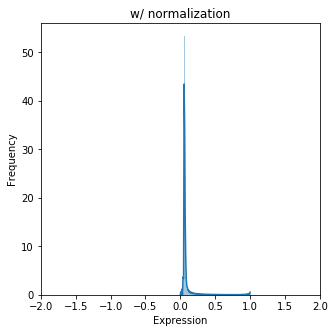

In [11]:
#Sample obs distribution
fig, ax = plt.subplots(figsize=(5,5))
sb.distplot(X_train_scaled.flatten(),bins=200,ax=ax)
ax.set_xlim(-2,2)
ax.set(xlabel='Expression', ylabel='Frequency')
ax.set_title('w/ normalization')
plt.show()

In [11]:
X_predict_scaled , scaler_predict = utils.min_max(X=X_predict)

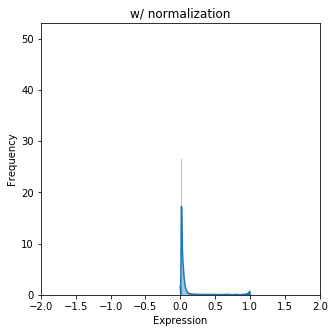

In [13]:
#Sample obs distribution
fig, ax = plt.subplots(figsize=(5,5))
sb.distplot(X_predict_scaled.flatten(),bins=200,ax=ax)
ax.set_xlim(-2,2)
ax.set(xlabel='Expression', ylabel='Frequency')
ax.set_title('w/ normalization')
plt.show()

In [12]:
Y_train_dummy,Y_train_ohe,encoder = utils.label_encoder(Y_train=Y_train)

/home/franciscogrisanti/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franciscogrisanti/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
x_train, x_test, y_train, y_test = utils.train_test_split(X_train_scaled,
                                                    Y_train_ohe,
                                                    test_size=0.10, 
                                                    random_state=40)

[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


In [14]:
class_weights = utils.get_class_weights(Y_train_ohe=y_train)
class_weights

array([0.64252979, 0.77287762, 5.84166667, 6.25892857, 0.69474727,
       6.31531532, 2.92083333, 2.93305439, 0.34481062, 0.82567727,
       4.70469799, 2.44250871, 1.31766917, 0.25743665, 6.20353982])

In [15]:
#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                      mode='min', 
                                      verbose=1,
                                      patience=30)

In [16]:
history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, y_test),
                    epochs=30,
                    class_weight=class_weight,
                    callbacks=[es])

Train on 10515 samples, validate on 1169 samples
Epoch 1/30
10515/10515 [==============================] - 2s 195us/sample - loss: 1.7949 - accuracy: 0.4929 - val_loss: 1.3038 - val_accuracy: 0.7246
Epoch 2/30
10515/10515 [==============================] - 2s 164us/sample - loss: 0.9330 - accuracy: 0.7956 - val_loss: 0.7266 - val_accuracy: 0.8289
Epoch 3/30
10515/10515 [==============================] - 2s 158us/sample - loss: 0.5756 - accuracy: 0.8532 - val_loss: 0.5276 - val_accuracy: 0.8580
Epoch 4/30
10515/10515 [==============================] - 2s 156us/sample - loss: 0.4226 - accuracy: 0.8811 - val_loss: 0.4282 - val_accuracy: 0.8768
Epoch 5/30
10515/10515 [==============================] - 2s 149us/sample - loss: 0.3302 - accuracy: 0.9078 - val_loss: 0.3615 - val_accuracy: 0.8905
Epoch 6/30
10515/10515 [==============================] - 2s 150us/sample - loss: 0.2651 - accuracy: 0.9302 - val_loss: 0.3251 - val_accuracy: 0.9059
Epoch 7/30
10515/10515 [===========================

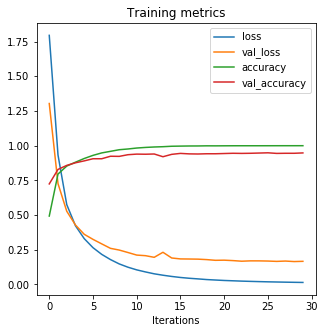

In [17]:
fig, axs = plt.subplots(figsize=(5,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training metrics')
plt.xlabel('Iterations')
plt.legend()

In [18]:
utils.print_metrics(model=model,
                  x_train=x_train,
                  y_train=y_train,
                  x_test=x_test,
                  y_test=y_test)

[INFO] Accuracy -- Train: 1.000, Test: 0.948
[INFO] ROC -- Train: 1.000, Test: 0.998


In [19]:
predictions = utils.make_predictions(model=model,
                     X_predict=X_predict_scaled,
                     encoder=encoder,
                     adata_predict=adata_predict,
                     probabilities=False,
                     save=True
                    )
predictions

,X,Y,n_counts,log_counts,n_genes,mt_frac,FOV,STANN_predictions
barcode,,,,,,,,
0a,1766.40,283.42,1148.0,7.045776,717,0.0,0,Astro
1a,1891.40,348.38,841.0,6.734591,555,0.0,0,Neuron_GC
2a,1548.70,351.11,1704.0,7.440734,1066,0.0,0,Neuron_GC
3a,1657.60,357.37,1439.0,7.271704,940,0.0,0,OEC
4a,1767.40,392.22,1657.0,7.412764,1060,0.0,0,Neuron_GC
...,...,...,...,...,...,...,...,...
2045a,339.97,1532.30,853.0,6.748760,539,0.0,6,OEC
2046a,608.31,1544.70,735.0,6.599871,463,0.0,6,OEC
2047a,779.11,1551.90,822.0,6.711740,543,0.0,6,OEC
